<a href="https://colab.research.google.com/github/johntanas/it1244project/blob/main/code/label.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [4]:
onlinedataset=True
if onlinedataset:
  url = "https://drive.google.com/file/d/1TBcW6O9KMRMh9CWf36OIjZwvY-qzH1VS/view?usp=sharing"
  url='https://drive.google.com/uc?id=' + url.split('/')[-2]
  credit_record=pd.read_csv(url,index_col=0)
else:
  pathtodataset="/content/credit_record.csv"
  credit_record=pd.read_csv(pathtodataset,index_col=0)
path_to_app="/content/cleaned_application.csv"
#cleaned_app_df=pd.read_csv(path_to_app,index_col=0)

In [5]:
credit_record

,id,month_bal,status
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C
...,...,...,...
1048570,5150487,-25,C
1048571,5150487,-26,C
1048572,5150487,-27,C
1048573,5150487,-28,C


In [6]:
credit_record["month_bal"].unique(),credit_record["status"].unique()

(array([  0,  -1,  -2,  -3,  -4,  -5,  -6,  -7,  -8,  -9, -10, -11, -12,
        -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25,
        -26, -27, -28, -29, -30, -31, -32, -33, -34, -35, -36, -37, -38,
        -39, -40, -41, -42, -43, -44, -45, -46, -47, -48, -49, -50, -51,
        -52, -53, -54, -55, -56, -57, -58, -59, -60]),
 array(['X', '0', 'C', '1', '2', '3', '4', '5'], dtype=object))

In [7]:
to_avg={"X":-1,"C":0}
for i in range(6):
  to_avg[str(i)]=i+1

In [8]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [9]:
credit_record=credit_record.replace({"status":to_avg})

In [10]:
credit_record

,id,month_bal,status
0,5001711,0,-1
1,5001711,-1,1
2,5001711,-2,1
3,5001711,-3,1
4,5001712,0,0
...,...,...,...
1048570,5150487,-25,0
1048571,5150487,-26,0
1048572,5150487,-27,0
1048573,5150487,-28,0


In [11]:
series=credit_record.groupby("id")["status"].mean()

In [12]:
X=StandardScaler().fit_transform(np.array(series).reshape(-1,1))

https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/

In [13]:
inertias = []
mapping2 = {}
K = range(1, 10)
  
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    inertias.append(kmeanModel.inertia_)
  
    mapping2[k] = kmeanModel.inertia_

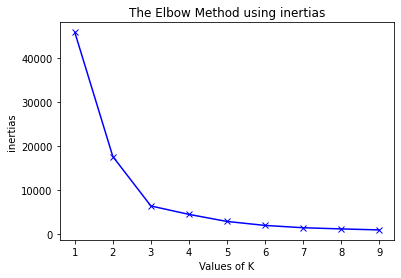

In [14]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('inertias')
plt.title('The Elbow Method using inertias')
plt.show()

It seems K=4 is the elbow

In [15]:
df=pd.DataFrame(series)
label1=df.copy()

We repeat Kmeans with 30 random states as 30 already is a statisically large sample size

In [16]:
maxInertia=float("INF")
bestkmeans=None
for i in range(30):
  kmeanModel = KMeans(n_clusters=4,random_state=i).fit(X)
  kmeanModel.fit(X)
  if kmeanModel.inertia_<maxInertia:
    print(f"better clusters found with inertia = {kmeanModel.inertia_} at \n{kmeanModel.cluster_centers_}")
    bestkmeans=kmeanModel
    maxInertia=kmeanModel.inertia_


better clusters found with inertia = 4447.283591952056 at 
[[-0.33006697]
 [ 1.12126491]
 [-1.94281256]
 [ 0.34058123]]
better clusters found with inertia = 4445.895119846266 at 
[[-0.33867348]
 [ 1.11751472]
 [-1.94513759]
 [ 0.32708314]]


In [17]:
label1["label"]=bestkmeans.labels_

In [18]:
bestkmeans.cluster_centers_

array([[-0.33867348],
       [ 1.11751472],
       [-1.94513759],
       [ 0.32708314]])

Cluster 1 is good, cluster 2 is  very bad, cluster 3 is very good,cluster 4 is very bad. We can compress the groups into 2 classes later as we would be losing information if we compress them before we add into our neural network/logistic regression

In [19]:
label_dict={0:"good",1:"bad",2:"very good",3:"very bad"}

In [20]:
out=label1.replace({"label":label_dict})

In [21]:
out.to_csv("average_label.csv")

We can also try kmeans on the exponential moving average!

In [22]:
descDf=credit_record.sort_values(['id','month_bal'],ascending=[True,True])

We set alpha = 0.5 to give receny bias

In [23]:
eMovingAvg=descDf.groupby("id")["status"].ewm(alpha=0.5).mean()

In [24]:
clustering2=eMovingAvg.groupby("id").nth([-1])

Find k clusters using elbow method

In [25]:
Xevm=StandardScaler().fit_transform(np.array(clustering2).reshape(-1, 1))

set k =2 (manual)

In [26]:
max2Inertia=float("INF")
best2kmeans=None
for i in range(30):
  kmeanModel = KMeans(n_clusters=2,random_state=i).fit(Xevm)
  kmeanModel.fit(Xevm)
  if kmeanModel.inertia_<max2Inertia:
    print(f"better clusters found with inertia = {kmeanModel.inertia_} at \n{kmeanModel.cluster_centers_}")
    best2kmeans=kmeanModel
    max2Inertia=kmeanModel.inertia_


better clusters found with inertia = 17978.587081434627 at 
[[ 1.39760856]
 [-0.43576841]]


In [27]:
label2=df.copy()

In [28]:
label2["label"]=best2kmeans.labels_

In [33]:
label_dict2={0:"bad",1:"good"}

In [34]:
out2=label2.replace({"label":label_dict2})

In [35]:
out2.to_csv("expo_moving_k2_labels.csv")